# PHBS_MLF_2023 Final Project

Team member:
- Zhou Enze 2201212447
- Wang Zixu 2201212423
- Li Zhongtian 2201212387

In [1]:
# install the latest version of scorecardpy from github
# !pip install git+https://github.com/shichenxie/scorecardpy.git

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

import warnings
import scorecardpy as sc

warnings.filterwarnings("ignore")

In [2]:
import itertools

# Create confusion matrix
def plot_confusion_matrix(cm, classes,
                         normalize = False,
                         title = "Confusion matrix",
                         cmap = plt.cm.Blues):
    if normalize:
        cn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    print(cm)
    
    plt.imshow(cm, interpolation = "nearest", cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

## 1. Data Description

In [3]:
train = pd.read_csv('../data/training.csv').drop(['split', 'id'], axis=1)
test = pd.read_csv('../data/test.csv').drop(['split', 'id'], axis=1)
train

,event,var1,var2,var3,var4,var5,var6,var7,var8
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1.0,2.096510e+07,NaN,NaN,NaN,NaN,NaN,62.750000
4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
238831,1,1.0,6.523118e+04,NaN,NaN,NaN,NaN,NaN,58.916667
238832,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238833,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238834,1,1.0,8.880325e+05,3.213,13.0,NaN,NaN,NaN,63.958333


##### Two main characteristics of training datasets:
1. Contains a large number of missing values.

In [4]:
# Check the missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238836 entries, 0 to 238835
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   event   238836 non-null  int64  
 1   var1    133036 non-null  float64
 2   var2    117036 non-null  float64
 3   var3    46637 non-null   float64
 4   var4    78187 non-null   float64
 5   var5    8287 non-null    float64
 6   var6    5939 non-null    float64
 7   var7    27542 non-null   float64
 8   var8    101147 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 16.4 MB


As the following figure shows, there are many missing values in all the features, so dealing with missing values will be extremely important.

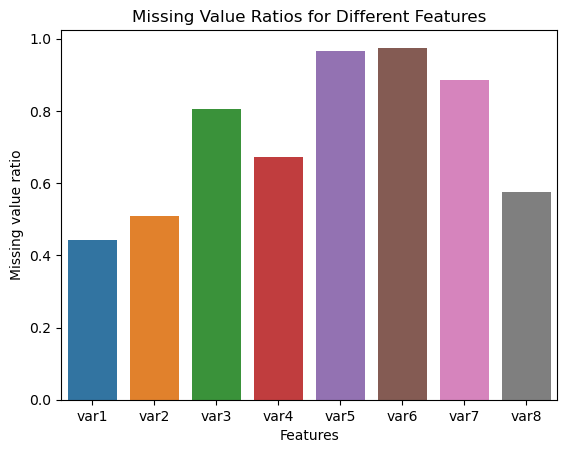

In [5]:
# View missing value ratio
# train_data = train

data_na = pd.DataFrame(train.drop(['event'], axis=1).isna().sum(axis=0) / len(train)).reset_index()
data_na.columns = ["Feature", "Ratio"]

bar, ax = plt.subplots()
ax = sns.barplot(x='Feature', y='Ratio', data=data_na)
ax.set_title('Missing Value Ratios for Different Features')
ax.set_xlabel('Features')
ax.set_ylabel('Missing value ratio')
plt.show()

2. Extremely imbalanced class distribution

In [8]:
train["event"].value_counts()

1    232804
0      6032
Name: event, dtype: int64

Moreover, the training data exhibit another trait: extremely imbalanced class distribution.

Label 1: 97.47 % of the dataset
Label 0: 2.53 % of the dataset


Text(0.5, 1.0, 'Class Distributions')

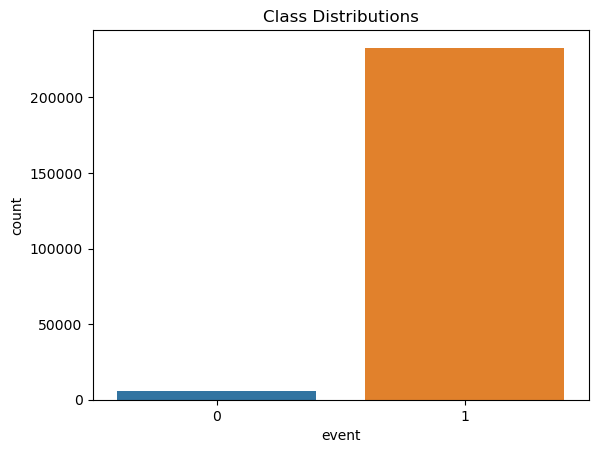

In [7]:
# Dataset severely imbalanced
print("Label 1:", round(train["event"].value_counts()[1] / len(train) * 100, 2),
      "% of the dataset")
print("Label 0:", round(train["event"].value_counts()[0] / len(train) * 100, 2),
      "% of the dataset")

# Draw Picture
sns.countplot(data=train, x='event')
plt.title("Class Distributions")

We calculate the ratio of positive class samples (`1`) over negative class samples (`0`) and this number is useful for tackling the imbalance issue when using `XGBoost`.

In [11]:
pos_neg_ratio = (train.event == 1).sum() / (train.event == 0).sum()
pos_neg_ratio

38.5948275862069

### Distribution of each feature:

In [12]:
train.describe()

,event,var1,var2,var3,var4,var5,var6,var7,var8
count,238836.000000,133036.000000,1.170360e+05,46637.000000,78187.000000,8287.000000,5939.000000,27542.000000,101147.000000
mean,0.974744,1.873951,5.989773e+06,16.772031,11.586977,289.199746,28.430493,20.646794,58.497153
std,0.156901,3.750522,3.444271e+07,125.433035,3.459597,5099.352261,2133.407579,6.460506,11.731754
min,0.000000,1.000000,0.000000e+00,0.000000,1.000000,0.000000,-3127.163978,2.000000,24.416667
25%,1.000000,1.000000,1.102558e+05,0.397341,13.000000,2.341317,0.012441,22.000000,49.833333
50%,1.000000,1.000000,8.042291e+05,1.509004,13.000000,8.105200,0.296218,24.000000,58.666667
75%,1.000000,1.000000,3.247496e+06,6.628049,13.000000,45.835062,1.378717,24.000000,66.666667
max,1.000000,121.000000,2.817428e+09,10175.481564,13.000000,334283.557143,164300.400000,24.000000,118.666667


We can also see that the distributions of all features are basically fat-tailed except for `var8`.

<AxesSubplot:ylabel='Density'>

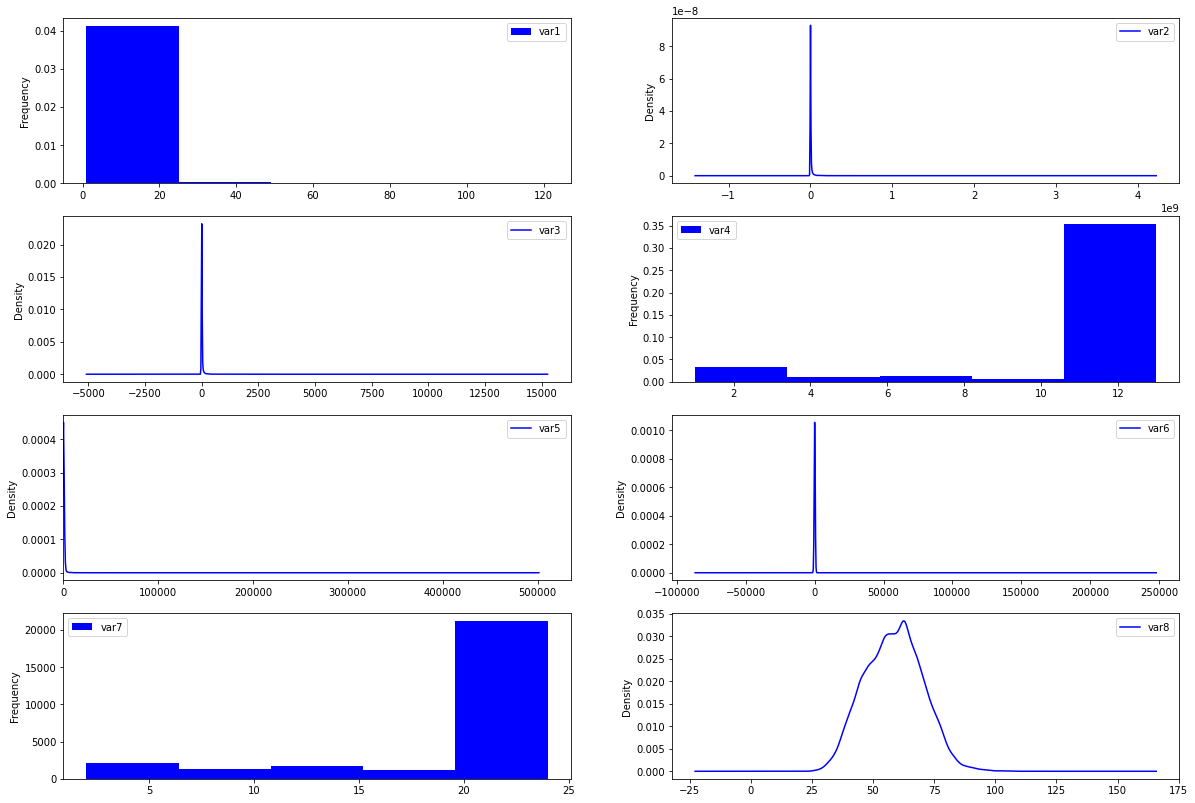

In [13]:
fig, ax = plt.subplots(4, 2, figsize=(20, 14))

# Draw the distrbution of features
train.plot(kind="hist", y="var1", bins=5, color="b", density=True,legend=True, ax=ax[(0,0)])
train.plot(kind="kde", y="var2", color="b", legend=True, ax=ax[(0,1)])
train.plot(kind="kde", y="var3", color="b", legend=True, ax=ax[(1,0)])
train.plot(kind="hist", y="var4", color="b", bins=5, legend=True, density=True, ax=ax[(1,1)])
train.plot(kind="kde", y="var5", color="b", xlim=0, legend=True, ax=ax[(2,0)])
train.plot(kind="kde", y="var6", color="b", legend=True, ax=ax[(2,1)])
train.plot(kind="hist", y="var7", color="b" ,bins=5, legend=True, ax=ax[(3,0)])
train.plot(kind="kde", y="var8", color="b", legend=True, ax=ax[(3,1)])

But we observe that the correlation between features are weak because all the correlations are of the scale $10^{-2}$, except for a few that are higher than $0.1$.

Text(0.5, 1.0, 'Correlation between features')

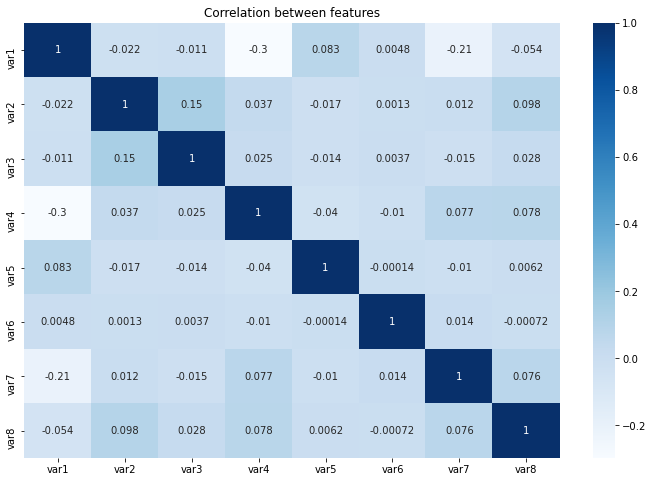

In [14]:
plt.figure(figsize=(12, 8))

sns.heatmap(train.drop(['event'], axis=1).corr(), annot=True, cmap='Blues')
plt.title('Correlation between features')

## 2. Data Engineering

### 2.1 Binning

In this subsection, we use the `scorecardpy` package to bin the features. The `woebin` first generates the initial bins, and then split the original bins so that the information value gain is greater than some threshold. After the binning procedure, the `woebin_ply` method will calculate the weight of evidence (WOE) for each bin and assign that value to each sample belong to that bin.

[INFO] creating woe binning ...
Binning on 238836 rows and 9 columns in 00:00:10


{'var7': <Figure size 432x288 with 2 Axes>,
 'var2': <Figure size 432x288 with 2 Axes>,
 'var6': <Figure size 432x288 with 2 Axes>,
 'var8': <Figure size 432x288 with 2 Axes>,
 'var5': <Figure size 432x288 with 2 Axes>,
 'var4': <Figure size 432x288 with 2 Axes>,
 'var3': <Figure size 432x288 with 2 Axes>,
 'var1': <Figure size 432x288 with 2 Axes>}

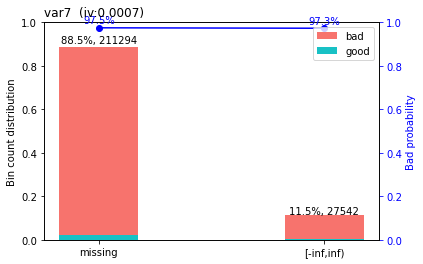

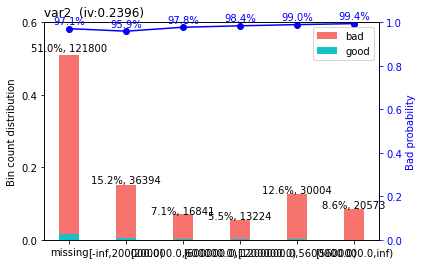

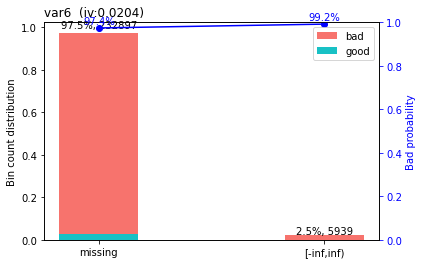

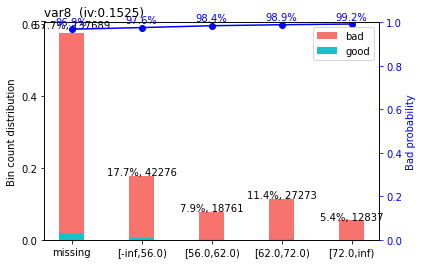

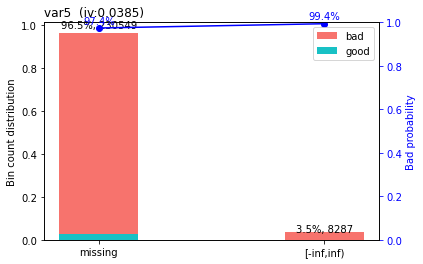

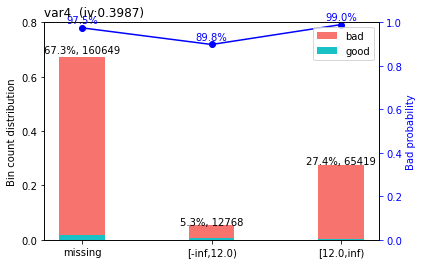

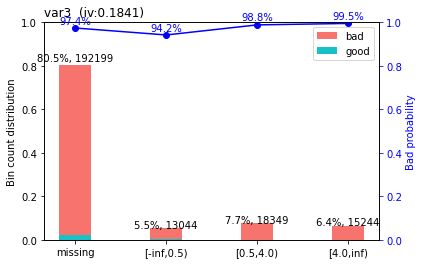

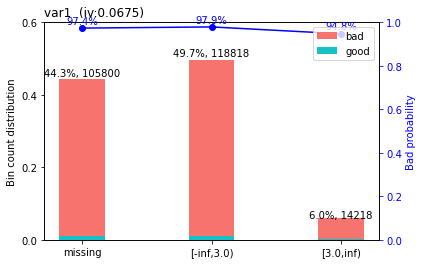

In [15]:
bins = sc.woebin(train, y="event")
sc.woebin_plot(bins)

In [16]:
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


From the following correlation plot, we observe that the correlations between features are still at a relatively low level, which means that the transformed features are still good for linear models.

Text(0.5, 1.0, 'Correlation between WOE transformed features')

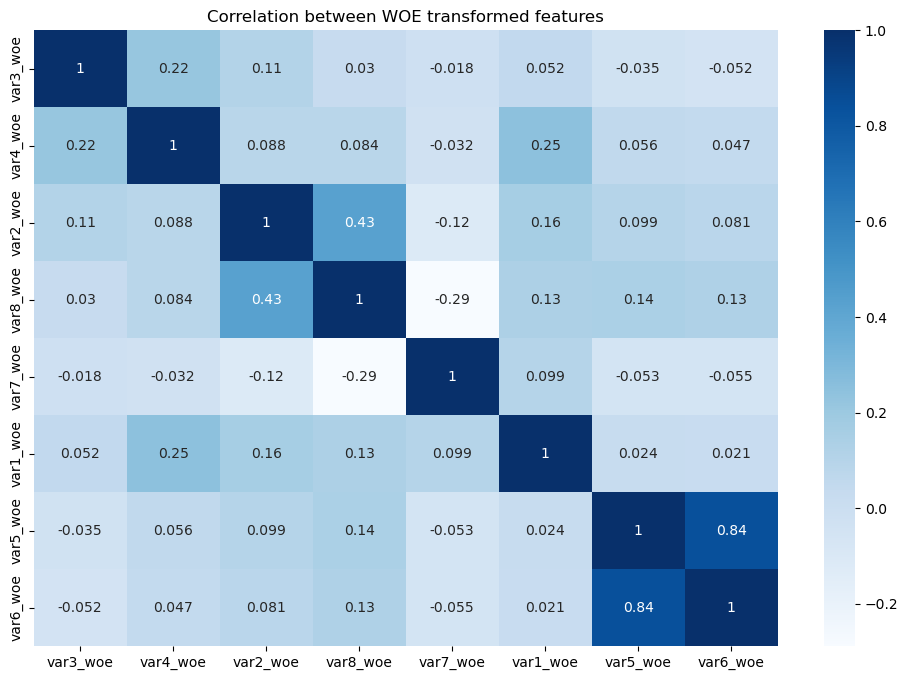

In [ ]:
plt.figure(figsize=(12, 8))

sns.heatmap(train_woe.drop(['event'], axis=1).corr(), annot=True, cmap='Blues')
plt.title('Correlation between WOE transformed features')

### 2.2 Feature Augmentation

In this subsection, we fill in the missing values using feature statistics (e.g. mode, median), and then create some new features by addition, subtraction, multiplication and division. That's why this subsection is called "feature augmentation".

In [17]:
train_fea_aug = train.copy()
test_fea_aug = test.copy()

In [18]:
train_fea_aug["allnan"] = 0
train_fea_aug.loc[train_fea_aug.isna().sum(axis=1) == 8, "allnan"] = 1

In [19]:
test_fea_aug["allnan"] = 0
test_fea_aug.loc[test_fea_aug.isna().sum(axis=1) == 8, "allnan"] = 1

Fill in missing values using statistics:
- For categorical variables (`var1`, `var4`, `var7`), use modes to fill in
- For continuous variables (`var2`, `var3`, `var5`, `var6`, `var8`), use medians to fill in

In [20]:
train_fea_aug["var1"] = train_fea_aug["var1"].fillna(value=st.mode(train_fea_aug.loc[:, "var1"], nan_policy='omit')[0][0])
train_fea_aug["var4"] = train_fea_aug["var4"].fillna(value=st.mode(train_fea_aug.loc[:, "var4"], nan_policy='omit')[0][0])
train_fea_aug["var7"] = train_fea_aug["var7"].fillna(value=st.mode(train_fea_aug.loc[:, "var7"], nan_policy='omit')[0][0])

In [21]:
test_fea_aug["var1"] = test_fea_aug["var1"].fillna(value=st.mode(test_fea_aug.loc[:, "var1"], nan_policy='omit')[0][0])
test_fea_aug["var4"] = test_fea_aug["var4"].fillna(value=st.mode(test_fea_aug.loc[:, "var4"], nan_policy='omit')[0][0])
test_fea_aug["var7"] = test_fea_aug["var7"].fillna(value=st.mode(test_fea_aug.loc[:, "var7"], nan_policy='omit')[0][0])

In [22]:
con_var = ["var2", "var3", "var5", "var6", "var8"]
for i in con_var:
    train_fea_aug[i] = train_fea_aug[i].fillna(value=train_fea_aug.loc[: ,i].median())

In [23]:
for i in con_var:
    test_fea_aug[i] = test_fea_aug[i].fillna(value=test_fea_aug.loc[: ,i].median())

In [24]:
X = train_fea_aug.drop(['event'], axis=1).copy()
event = train_fea_aug.event.copy()

In [25]:
feature_list = list(X.columns)

for x in feature_list:
    X[x+"^2"] = X[x] * X[x]
    X["abs_"+x] = abs(X[x])
    for y in feature_list:
        if x!=y:
            X[x+"_add_"+y] = X[x]+X[y]
            X[x+"_mns_"+y] = X[x]-X[y]
            X[x+"_multi_"+y] = X[x] * X[y]
            X[x+"_dvd_"+y] = X[x] / (X[y]+0.1) # in case X[y] = 0

train_fea_aug = X.copy()
train_fea_aug['event'] = event
train_fea_aug

,var1,var2,var3,var4,var5,var6,var7,var8,allnan,var1^2,...,allnan_dvd_var6,allnan_add_var7,allnan_mns_var7,allnan_multi_var7,allnan_dvd_var7,allnan_add_var8,allnan_mns_var8,allnan_multi_var8,allnan_dvd_var8,event
0,1.0,8.042291e+05,1.509004,13.0,8.1052,0.296218,24.0,58.666667,1,1.0,...,2.523864,25.0,-23.0,24.0,0.041494,59.666667,-57.666667,58.666667,0.017016,1
1,1.0,8.042291e+05,1.509004,13.0,8.1052,0.296218,24.0,58.666667,1,1.0,...,2.523864,25.0,-23.0,24.0,0.041494,59.666667,-57.666667,58.666667,0.017016,1
2,1.0,8.042291e+05,1.509004,13.0,8.1052,0.296218,24.0,58.666667,1,1.0,...,2.523864,25.0,-23.0,24.0,0.041494,59.666667,-57.666667,58.666667,0.017016,1
3,1.0,2.096510e+07,1.509004,13.0,8.1052,0.296218,24.0,62.750000,0,1.0,...,0.000000,24.0,-24.0,0.0,0.000000,62.750000,-62.750000,0.000000,0.000000,1
4,1.0,8.042291e+05,1.509004,13.0,8.1052,0.296218,24.0,58.666667,1,1.0,...,2.523864,25.0,-23.0,24.0,0.041494,59.666667,-57.666667,58.666667,0.017016,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238831,1.0,6.523118e+04,1.509004,13.0,8.1052,0.296218,24.0,58.916667,0,1.0,...,0.000000,24.0,-24.0,0.0,0.000000,58.916667,-58.916667,0.000000,0.000000,1
238832,1.0,8.042291e+05,1.509004,13.0,8.1052,0.296218,24.0,58.666667,0,1.0,...,0.000000,24.0,-24.0,0.0,0.000000,58.666667,-58.666667,0.000000,0.000000,1
238833,1.0,8.042291e+05,1.509004,13.0,8.1052,0.296218,24.0,58.666667,1,1.0,...,2.523864,25.0,-23.0,24.0,0.041494,59.666667,-57.666667,58.666667,0.017016,1
238834,1.0,8.880325e+05,3.213000,13.0,8.1052,0.296218,24.0,63.958333,0,1.0,...,0.000000,24.0,-24.0,0.0,0.000000,63.958333,-63.958333,0.000000,0.000000,1


In [26]:
X = test_fea_aug.drop(['event'], axis=1).copy()
event = test_fea_aug.event.copy()

feature_list = list(X.columns)

for x in feature_list:
    X[x+"^2"] = X[x] * X[x]
    X["abs_"+x] = abs(X[x])
    for y in feature_list:
        if x!=y:
            X[x+"_add_"+y] = X[x]+X[y]
            X[x+"_mns_"+y] = X[x]-X[y]
            X[x+"_multi_"+y] = X[x] * X[y]
            X[x+"_dvd_"+y] = X[x] / (X[y]+0.1) # in case X[y] = 0

test_fea_aug = X.copy()
test_fea_aug['event'] = event
test_fea_aug

,var1,var2,var3,var4,var5,var6,var7,var8,allnan,var1^2,...,allnan_dvd_var6,allnan_add_var7,allnan_mns_var7,allnan_multi_var7,allnan_dvd_var7,allnan_add_var8,allnan_mns_var8,allnan_multi_var8,allnan_dvd_var8,event
0,1.0,9.248254e+07,0.908051,13.0,0.133592,0.027241,24.0,73.041667,0,1.0,...,0.000000,24.0,-24.0,0.0,0.000000,73.041667,-73.041667,0.00,0.000000,1
1,1.0,8.263664e+05,1.470276,4.0,7.976950,0.205745,24.0,58.750000,0,1.0,...,0.000000,24.0,-24.0,0.0,0.000000,58.750000,-58.750000,0.00,0.000000,1
2,1.0,6.718715e+06,7.035461,13.0,41.878073,-7.422937,24.0,76.250000,0,1.0,...,-0.000000,24.0,-24.0,0.0,0.000000,76.250000,-76.250000,0.00,0.000000,1
3,1.0,3.576348e+06,0.483255,13.0,60.801780,0.205745,24.0,80.083333,0,1.0,...,0.000000,24.0,-24.0,0.0,0.000000,80.083333,-80.083333,0.00,0.000000,1
4,1.0,8.443072e+06,1.470276,13.0,0.525225,0.205745,24.0,87.625000,0,1.0,...,0.000000,24.0,-24.0,0.0,0.000000,87.625000,-87.625000,0.00,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59704,1.0,1.060430e+06,1.470276,13.0,7.976950,0.205745,24.0,58.750000,0,1.0,...,0.000000,24.0,-24.0,0.0,0.000000,58.750000,-58.750000,0.00,0.000000,1
59705,1.0,8.263664e+05,1.470276,13.0,7.976950,0.205745,24.0,58.750000,1,1.0,...,3.270695,25.0,-23.0,24.0,0.041494,59.750000,-57.750000,58.75,0.016992,1
59706,1.0,1.593264e+07,1.470276,13.0,7.976950,0.205745,24.0,58.750000,0,1.0,...,0.000000,24.0,-24.0,0.0,0.000000,58.750000,-58.750000,0.00,0.000000,1
59707,1.0,8.263664e+05,1.470276,13.0,7.976950,0.205745,24.0,58.750000,1,1.0,...,3.270695,25.0,-23.0,24.0,0.041494,59.750000,-57.750000,58.75,0.016992,1


### 2.3 Random Forest Imputation

In this subsection, we fill in the missing values using random forest. The rationale behind method is that when samples have a portion of similar existing features, they may have similar values for the rest of the features (the missing ones). Therefore, we can use random forest to "interpolate" the missing values.

In [27]:
X = train.drop(['event'], axis=1).copy()
y = train.event.copy()

n_samples = X.shape[0] 
n_features = X.shape[1]

X_missing_reg = X.copy()

X_df = X_missing_reg.isnull().sum()
# Obtain colnames according to missing value ratio from small to large
colname = X_df[~X_df.isin([0])].sort_values().index.values
sortindex = []
for i in colname:
    sortindex.append(X_missing_reg.columns.tolist().index(str(i)))
sortindex

[0, 1, 7, 3, 2, 6, 4, 5]

In [28]:
# Traverse all features, starting from the one with the least missing, and fill in. 
# After each regression prediction is completed, 
# the predicted value is placed in the original feature matrix before continuing to fill in the next feature.

# Create 8 random forest regressors to fill in missing values
# These regressors are used to fill in the missing values of both train and test set
rfrs = [RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1) for i in range(X_missing_reg.shape[1])]

for i in sortindex:
    df = X_missing_reg
    fillc = df.iloc[:, i]
    df = df.drop(df.columns[i], axis=1)
    df_0 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0).fit_transform(df)
    Ytrain = fillc[fillc.notnull()]
    Yprec = fillc[fillc.isnull()]
    Xtrain = df_0[Ytrain.index, :]
    Xprec = df_0[Yprec.index, :]
    rfr = rfrs[i]
    rfr = rfr.fit(Xtrain, Ytrain)
    Yimpute = rfr.predict(Xprec)
    X_missing_reg.loc[X_missing_reg.iloc[:, i].isnull(), X_missing_reg.columns[i]] = Yimpute

In [29]:
# Check again if all missing values have been replaced
missing1 = X_missing_reg.isna().sum()
missing1 = pd.DataFrame(data={'Colname': missing1.index, 'Missing Value Number': missing1.values})

print(missing1)

  Colname  Missing Value Number
0    var1                     0
1    var2                     0
2    var3                     0
3    var4                     0
4    var5                     0
5    var6                     0
6    var7                     0
7    var8                     0


In [30]:
train_rf_impute = pd.concat([X_missing_reg, pd.DataFrame(y)], axis=1)
train_rf_impute

,var1,var2,var3,var4,var5,var6,var7,var8,event
0,1.390938,5.511623e+06,41.735989,13.000000,87.629355,0.949841,21.570588,42.990827,1
1,1.390938,5.511623e+06,41.735989,13.000000,87.629355,0.949841,21.570588,42.990827,1
2,1.390938,5.511623e+06,41.735989,13.000000,87.629355,0.949841,21.570588,42.990827,1
3,1.000000,2.096510e+07,45.072275,12.441065,87.629355,1.078501,21.606118,62.750000,1
4,1.390938,5.511623e+06,41.735989,13.000000,87.629355,0.949841,21.570588,42.990827,1
...,...,...,...,...,...,...,...,...,...
238831,1.000000,6.523118e+04,5.952482,12.097502,200.738566,-68.248624,21.599794,58.916667,1
238832,1.000000,5.511623e+06,17.420969,12.441065,87.629355,1.216800,21.606118,61.961797,1
238833,1.390938,5.511623e+06,41.735989,13.000000,87.629355,0.949841,21.570588,42.990827,1
238834,1.000000,8.880325e+05,3.213000,13.000000,87.629355,2.151530,21.550555,63.958333,1


From the correlation plot below, we can see that the correlation between features don't change much, implying that we didn't introduce much correlation into features using the random forest imputing approach which is a good sign because we don't want highly correlated features.

Text(0.5, 1.0, 'Correlation between random forest imputed features')

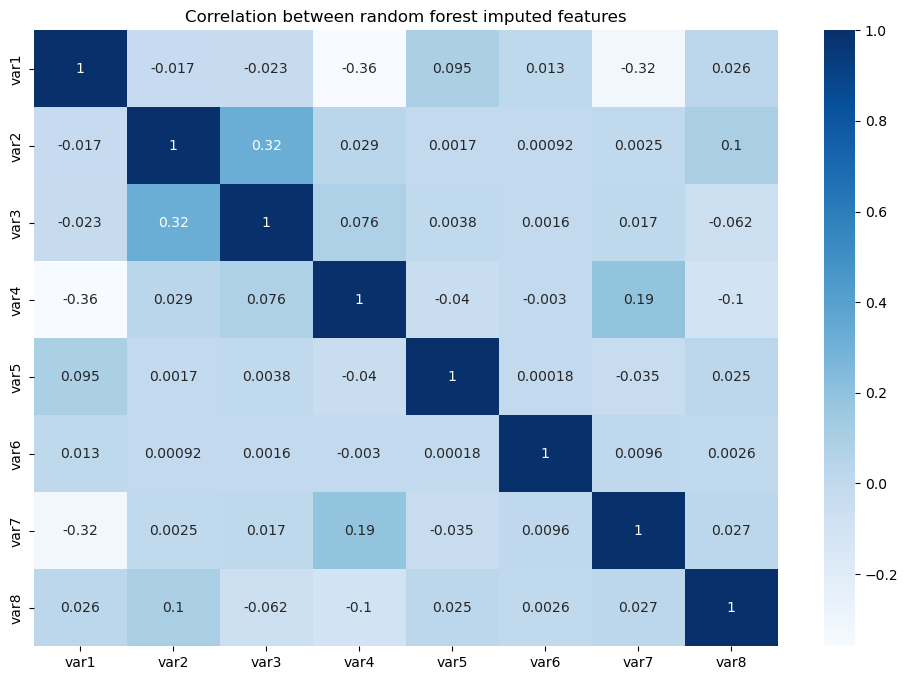

In [ ]:
plt.figure(figsize=(12, 8))

sns.heatmap(train_rf_impute.drop(['event'], axis=1).corr(), annot=True, cmap='Blues')
plt.title('Correlation between random forest imputed features')

Same process for test data, but this time use the random forest regressors above to impute the missing values

In [31]:
X_missing_reg = test.drop(['event'], axis=1).copy()

In [32]:
for i in sortindex:
    df = X_missing_reg
    fillc = df.iloc[:, i]
    df = df.drop(df.columns[i], axis=1)
    df_0 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0).fit_transform(df)
    Ytrain = fillc[fillc.notnull()]
    Yprec = fillc[fillc.isnull()]
    Xtrain = df_0[Ytrain.index, :]
    Xprec = df_0[Yprec.index, :]
    rfr = rfrs[i]
    # rfr = rfr.fit(Xtrain, Ytrain)
    Yimpute = rfr.predict(Xprec)
    X_missing_reg.loc[X_missing_reg.iloc[:, i].isnull(), X_missing_reg.columns[i]] = Yimpute

In [33]:
# Check again if all missing values have been replaced
missing2 = X_missing_reg.isna().sum()
missing2 = pd.DataFrame(data={'Colname': missing2.index, 'Missing Value Number': missing2.values})

print(missing2)

  Colname  Missing Value Number
0    var1                     0
1    var2                     0
2    var3                     0
3    var4                     0
4    var5                     0
5    var6                     0
6    var7                     0
7    var8                     0


In [34]:
test_rf_impute = pd.concat([X_missing_reg, test.event], axis=1)
test_rf_impute

,var1,var2,var3,var4,var5,var6,var7,var8,event
0,1.000000,9.248254e+07,0.908051,13.000000,0.133592,0.027241,20.910878,73.041667,1
1,2.551889,1.509778e+06,3.691273,4.000000,225.656144,4.054406,19.736057,53.621254,1
2,1.000000,6.718715e+06,7.035461,13.000000,41.878073,-7.422937,21.722927,76.250000,1
3,1.000000,3.576348e+06,0.483255,13.000000,60.801780,1.499363,21.667364,80.083333,1
4,1.000000,8.443072e+06,17.162651,12.441065,0.525225,1.174177,21.722927,87.625000,1
...,...,...,...,...,...,...,...,...,...
59704,1.000000,1.060430e+06,7.791286,12.189818,178.348478,2.839044,21.606118,61.961797,1
59705,1.390938,5.511623e+06,41.735989,13.000000,87.629355,0.949841,21.570588,42.990827,1
59706,1.000000,1.593264e+07,20.047323,12.441065,87.629355,1.218996,21.705673,67.539275,1
59707,1.390938,5.511623e+06,41.735989,13.000000,87.629355,0.949841,21.570588,42.990827,1


## 3. Model Building

In this section, we use several models to predict the outcome of the test set, including Logistic Regression, Random Forest and XGBoost. And for each algorithm, we apply different data to them, including all the data we get above. We organize the performance of all models in a pandas DataFrame, see section 4 for details.

In [35]:
model_performance = pd.DataFrame(columns=['model', 'auc', 'accuracy', 'precision', 'recall', 'f1'])

### 3.1 Baseline Using XGBoost

First of all, we build a baseline model with `XGBoost` and the raw data (without missing value imputation and binning).

In [36]:
xgb_bl = XGBClassifier(random_state=42, scale_pos_weight=1/pos_neg_ratio)

param_grid_xgb_bl = {'n_estimators': [20, 30, 50],
                     'max_depth': [3, 5, 6, 7, 8, 9, 10]}

gs_xgb_bl = GridSearchCV(xgb_bl, param_grid_xgb_bl, scoring='roc_auc', cv=5, refit=True, n_jobs=-1, verbose=1)
gs_xgb_bl.fit(train.drop('event', axis=1), train.event)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[19:17:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None,
                                     scale_pos_weight=0.025910207728389548,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [20, 30, 50]},
             scoring='roc_auc', verbose=1)

In [37]:
fpr_xgb_bl, tpr_xgb_bl, thresholds_xgb_bl = roc_curve(test.event, gs_xgb_bl.predict_proba(test.drop('event', axis=1))[:,1])
auc_xgb_bl = auc(fpr_xgb_bl, tpr_xgb_bl)

acc_xgb_bl = accuracy_score(test.event, gs_xgb_bl.predict(test.drop('event', axis=1)))
prec_xgb_bl = precision_score(test.event, gs_xgb_bl.predict(test.drop('event', axis=1)), pos_label=0)
rec_xgb_bl = recall_score(test.event, gs_xgb_bl.predict(test.drop('event', axis=1)), pos_label=0)
f1_xgb_bl = f1_score(test.event, gs_xgb_bl.predict(test.drop('event', axis=1)), pos_label=0)

Confusion matrix, without normalization
[[ 1235   258]
 [28685 29531]]
Confusion matrix, without normalization
[[ 1493     0]
 [    0 58216]]


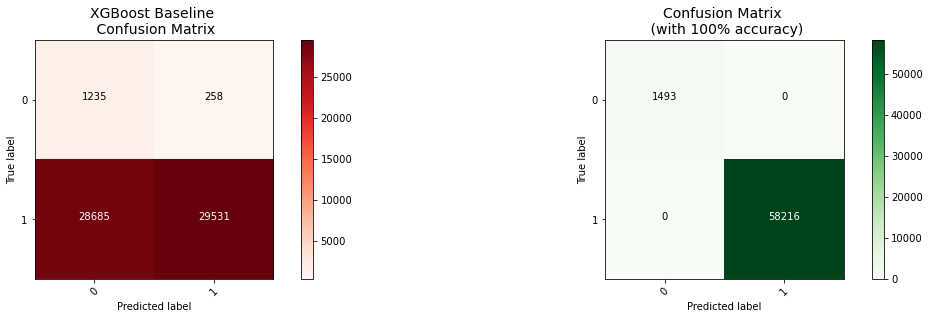

In [38]:
cm = confusion_matrix(test["event"].values, gs_xgb_bl.predict(test.drop('event', axis=1)))
actual_cm = confusion_matrix(test["event"].values,test["event"].values)
labels = ["0", "1"]

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(cm, labels, title="XGBoost Baseline \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

Here, we plot the confusion matrix of the model on the left. The spurious confusion matrix on the right (for comparison) is what a perfect algorithm would yield. All of the following confusion matrices adopt this paradigm.

In [39]:
model_performance = model_performance.append({'model': 'XGBoost_baseline', 'auc': auc_xgb_bl, 'accuracy': acc_xgb_bl, 'precision': prec_xgb_bl, 'recall': rec_xgb_bl, 'f1': f1_xgb_bl}, ignore_index=True)

### 3.2 Using Data after Binning

#### 3.2.1 Logistic Regression

In [41]:
pipeline_lr_bin = Pipeline([('scaler', StandardScaler()),
                            ('lr', LogisticRegression(random_state=42, class_weight='balanced'))])

param_grid_lr_bin = {'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
                     'lr__penalty': ['l1', 'l2']}

gs_lr_bin = GridSearchCV(pipeline_lr_bin, param_grid_lr_bin, scoring='roc_auc', cv=5, refit=True, n_jobs=-1, verbose=1)
gs_lr_bin.fit(train_woe.drop('event', axis=1), train_woe.event)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'lr__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [42]:
fpr_lr_bin, tpr_lr_bin, thresholds_lr_bin = roc_curve(test_woe.event, gs_lr_bin.predict_proba(test_woe.drop('event', axis=1))[:,1])
auc_lr_bin = auc(fpr_lr_bin, tpr_lr_bin)

acc_lr_bin = accuracy_score(test_woe.event, gs_lr_bin.predict(test_woe.drop('event', axis=1)))
prec_lr_bin = precision_score(test_woe.event, gs_lr_bin.predict(test_woe.drop('event', axis=1)), pos_label=0)
rec_lr_bin = recall_score(test_woe.event, gs_lr_bin.predict(test_woe.drop('event', axis=1)), pos_label=0)
f1_lr_bin = f1_score(test_woe.event, gs_lr_bin.predict(test_woe.drop('event', axis=1)), pos_label=0)

Confusion matrix, without normalization
[[ 1234   259]
 [29651 28565]]
Confusion matrix, without normalization
[[ 1493     0]
 [    0 58216]]


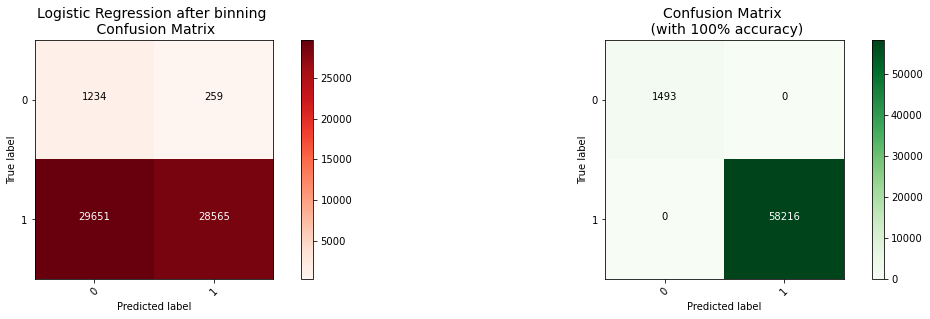

In [43]:
cm = confusion_matrix(test["event"].values, gs_lr_bin.predict(test_woe.drop('event', axis=1)))
actual_cm = confusion_matrix(test["event"].values,test["event"].values)
labels = ["0", "1"]

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(cm, labels, title="Logistic Regression after binning \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [44]:
model_performance = model_performance.append({'model': 'LogisticRegression (binned data)', 'auc': auc_lr_bin, 'accuracy': acc_lr_bin, 'precision': prec_lr_bin, 'recall': rec_lr_bin, 'f1': f1_lr_bin}, ignore_index=True)

#### 3.2.2 Random Forest

In [46]:
pipeline_rf_bin = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid_rf_bin = {'n_estimators': [20, 30, 50],
                     'max_depth': [3, 5, 6, 7, 8, 9, 10]}

gs_rf_bin = GridSearchCV(pipeline_rf_bin, param_grid_rf_bin, scoring='roc_auc', cv=5, refit=True, n_jobs=-1, verbose=1)
gs_rf_bin.fit(train_woe.drop('event', axis=1), train_woe.event)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [20, 30, 50]},
             scoring='roc_auc', verbose=1)

In [47]:
fpr_rf_bin, tpr_rf_bin, thresholds_rf_bin = roc_curve(test_woe.event, gs_rf_bin.predict_proba(test_woe.drop('event', axis=1))[:,1])
auc_rf_bin = auc(fpr_rf_bin, tpr_rf_bin)

acc_rf_bin = accuracy_score(test_woe.event, gs_rf_bin.predict(test_woe.drop('event', axis=1)))
prec_rf_bin = precision_score(test_woe.event, gs_rf_bin.predict(test_woe.drop('event', axis=1)), pos_label=0)
rec_rf_bin = recall_score(test_woe.event, gs_rf_bin.predict(test_woe.drop('event', axis=1)), pos_label=0)
f1_rf_bin = f1_score(test_woe.event, gs_rf_bin.predict(test_woe.drop('event', axis=1)), pos_label=0)

Confusion matrix, without normalization
[[ 1216   277]
 [28500 29716]]
Confusion matrix, without normalization
[[ 1493     0]
 [    0 58216]]


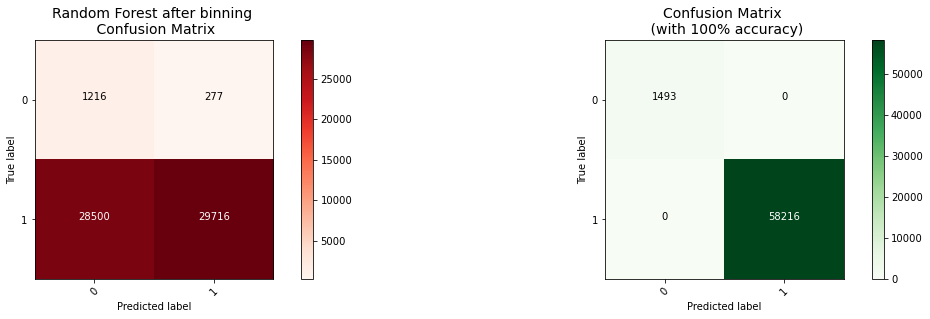

In [48]:
cm = confusion_matrix(test["event"].values, gs_rf_bin.predict(test_woe.drop('event', axis=1)))
actual_cm = confusion_matrix(test["event"].values,test["event"].values)
labels = ["0", "1"]

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(cm, labels, title="Random Forest after binning \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [49]:
model_performance = model_performance.append({'model': 'RandomForest (binned data)', 'auc': auc_rf_bin, 'accuracy': acc_rf_bin, 'precision': prec_rf_bin, 'recall': rec_rf_bin, 'f1': f1_rf_bin}, ignore_index=True)

#### 3.2.3 XGBoost

In [50]:
pipeline_xgb_bin = XGBClassifier(random_state=42, scale_pos_weight=1/pos_neg_ratio)

param_grid_xgb_bin = {'n_estimators': [20, 30, 50],
                      'max_depth': [3, 5, 6, 7, 8, 9, 10]}

gs_xgb_bin = GridSearchCV(pipeline_xgb_bin, param_grid_xgb_bin, scoring='roc_auc', cv=5, refit=True, n_jobs=-1, verbose=1)
gs_xgb_bin.fit(train_woe.drop('event', axis=1), train_woe.event)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[19:26:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None,
                                     scale_pos_weight=0.025910207728389548,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [20, 30, 50]},
             scoring='roc_auc', verbose=1)

In [51]:
fpr_xgb_bin, tpr_xgb_bin, thresholds_xgb_bin = roc_curve(test_woe.event, gs_xgb_bin.predict_proba(test_woe.drop('event', axis=1))[:,1])
auc_xgb_bin = auc(fpr_xgb_bin, tpr_xgb_bin)

acc_xgb_bin = accuracy_score(test_woe.event, gs_xgb_bin.predict(test_woe.drop('event', axis=1)))
prec_xgb_bin = precision_score(test_woe.event, gs_xgb_bin.predict(test_woe.drop('event', axis=1)), pos_label=0)
rec_xgb_bin = recall_score(test_woe.event, gs_xgb_bin.predict(test_woe.drop('event', axis=1)), pos_label=0)
f1_xgb_bin = f1_score(test_woe.event, gs_xgb_bin.predict(test_woe.drop('event', axis=1)), pos_label=0)

Confusion matrix, without normalization
[[ 1232   261]
 [29276 28940]]
Confusion matrix, without normalization
[[ 1493     0]
 [    0 58216]]


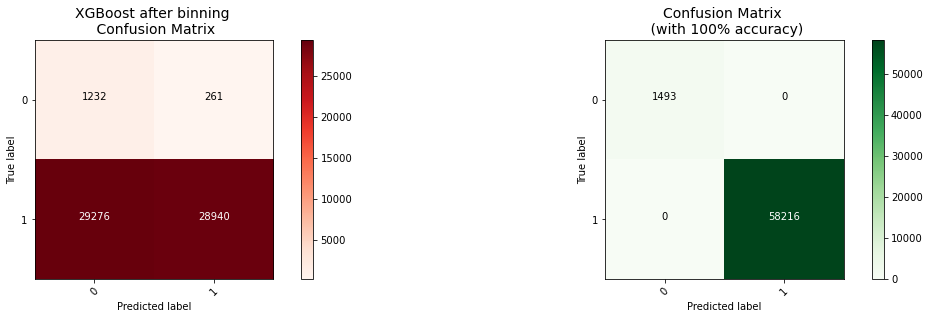

In [52]:
cm = confusion_matrix(test["event"].values, gs_xgb_bin.predict(test_woe.drop('event', axis=1)))
actual_cm = confusion_matrix(test["event"].values,test["event"].values)
labels = ["0", "1"]

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(cm, labels, title="XGBoost after binning \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [53]:
model_performance = model_performance.append({'model': 'XGBoost (binned data)', 'auc': auc_xgb_bin, 'accuracy': acc_xgb_bin, 'precision': prec_xgb_bin, 'recall': rec_xgb_bin, 'f1': f1_xgb_bin}, ignore_index=True)

### 3.3 Using Data After Binning and Oversampling

In [54]:
ovs = SMOTE(random_state=42)
X_binned_res, y_binned_res = ovs.fit_resample(train_woe.drop(['event'], axis=1), train_woe.event)

#### 3.3.1 Logistic Regression

In [55]:
pipeline_lr_ovs = Pipeline([('scaler', StandardScaler()),
                            ('lr', LogisticRegression(random_state=42, class_weight='balanced'))])

param_grid_lr_ovs = {'lr__C': [0.001, 0.01, 0.1, 1, 10, 100], 
                     'lr__penalty': ['l1', 'l2']}

gs_lr_ovs = GridSearchCV(pipeline_lr_ovs, param_grid_lr_ovs, scoring='roc_auc', cv=5, refit=True, n_jobs=-1, verbose=1)
gs_lr_ovs.fit(X_binned_res.values, y_binned_res.values)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'lr__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [56]:
fpr_lr_ovs, tpr_lr_ovs, thresholds_lr_ovs = roc_curve(test_woe.event, gs_lr_ovs.predict_proba(test_woe.drop('event', axis=1))[:,1])
auc_lr_ovs = auc(fpr_lr_ovs, tpr_lr_ovs)

acc_lr_ovs = accuracy_score(test_woe.event, gs_lr_ovs.predict(test_woe.drop('event', axis=1)))
prec_lr_ovs = precision_score(test_woe.event, gs_lr_ovs.predict(test_woe.drop('event', axis=1)), pos_label=0)
rec_lr_ovs = recall_score(test_woe.event, gs_lr_ovs.predict(test_woe.drop('event', axis=1)), pos_label=0)
f1_lr_ovs = f1_score(test_woe.event, gs_lr_ovs.predict(test_woe.drop('event', axis=1)), pos_label=0)

Confusion matrix, without normalization
[[ 1229   264]
 [29513 28703]]
Confusion matrix, without normalization
[[ 1493     0]
 [    0 58216]]


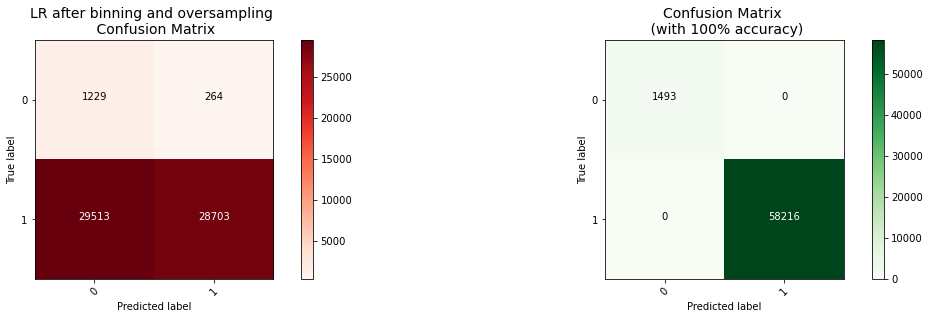

In [57]:
cm = confusion_matrix(test["event"].values, gs_lr_ovs.predict(test_woe.drop('event', axis=1)))
actual_cm = confusion_matrix(test["event"].values,test["event"].values)
labels = ["0", "1"]

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(cm, labels, title="LR after binning and oversampling \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [58]:
model_performance = model_performance.append({'model': 'Logistic Regression (binned & oversampled data)', 'auc': auc_lr_ovs, 'accuracy': acc_lr_ovs, 'precision': prec_lr_ovs, 'recall': rec_lr_ovs, 'f1': f1_lr_ovs}, ignore_index=True)

#### 3.3.2 Random Forest

In [59]:
pipeline_rf_ovs = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid_rf_ovs = {'n_estimators': [20, 30, 50],
                     'max_depth': [3, 5, 6, 7, 8, 9, 10]}

gs_rf_ovs = GridSearchCV(pipeline_rf_ovs, param_grid_rf_ovs, scoring='roc_auc', cv=5, refit=True, n_jobs=-1, verbose=1)
gs_rf_ovs.fit(X_binned_res.values, y_binned_res.values)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [20, 30, 50]},
             scoring='roc_auc', verbose=1)

In [60]:
fpr_rf_ovs, tpr_rf_ovs, thresholds_rf_ovs = roc_curve(test_woe.event, gs_rf_ovs.predict_proba(test_woe.drop('event', axis=1))[:,1])
auc_rf_ovs = auc(fpr_rf_ovs, tpr_rf_ovs)

acc_rf_ovs = accuracy_score(test_woe.event, gs_rf_ovs.predict(test_woe.drop('event', axis=1)))
prec_rf_ovs = precision_score(test_woe.event, gs_rf_ovs.predict(test_woe.drop('event', axis=1)), pos_label=0)
rec_rf_ovs = recall_score(test_woe.event, gs_rf_ovs.predict(test_woe.drop('event', axis=1)), pos_label=0)
f1_rf_ovs = f1_score(test_woe.event, gs_rf_ovs.predict(test_woe.drop('event', axis=1)), pos_label=0)

Confusion matrix, without normalization
[[ 1194   299]
 [28093 30123]]
Confusion matrix, without normalization
[[ 1493     0]
 [    0 58216]]


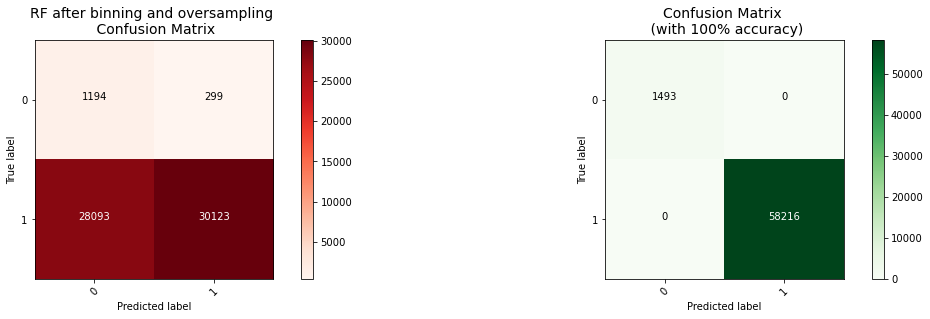

In [61]:
cm = confusion_matrix(test["event"].values, gs_rf_ovs.predict(test_woe.drop('event', axis=1)))
actual_cm = confusion_matrix(test["event"].values,test["event"].values)
labels = ["0", "1"]

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(cm, labels, title="RF after binning and oversampling \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [62]:
model_performance = model_performance.append({'model': 'Random Forest (binned & oversampled data)', 'auc': auc_rf_ovs, 'accuracy': acc_rf_ovs, 'precision': prec_rf_ovs, 'recall': rec_rf_ovs, 'f1': f1_rf_ovs}, ignore_index=True)

#### 3.3.3 XGBoost

In [63]:
pipeline_xgb_ovs = XGBClassifier(random_state=42, scale_pos_weight=1)

param_grid_xgb_ovs = {'n_estimators': [20, 30, 50],
                      'max_depth': [3, 5, 6, 7, 8, 9, 10]}

gs_xgb_ovs = GridSearchCV(pipeline_xgb_ovs, param_grid_xgb_ovs, scoring='roc_auc', cv=5, refit=True, n_jobs=-1, verbose=1)
gs_xgb_ovs.fit(X_binned_res.values, y_binned_res.values)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[19:38:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=1,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [20, 30, 50]},
             scoring='roc_auc', verbose=1)

In [64]:
fpr_xgb_ovs, tpr_xgb_ovs, thresholds_xgb_ovs = roc_curve(test_woe.event, gs_xgb_ovs.predict_proba(test_woe.drop('event', axis=1))[:,1])
auc_xgb_ovs = auc(fpr_xgb_ovs, tpr_xgb_ovs)

acc_xgb_ovs = accuracy_score(test_woe.event, gs_xgb_ovs.predict(test_woe.drop('event', axis=1)))
prec_xgb_ovs = precision_score(test_woe.event, gs_xgb_ovs.predict(test_woe.drop('event', axis=1)), pos_label=0)
rec_xgb_ovs = recall_score(test_woe.event, gs_xgb_ovs.predict(test_woe.drop('event', axis=1)), pos_label=0)
f1_xgb_ovs = f1_score(test_woe.event, gs_xgb_ovs.predict(test_woe.drop('event', axis=1)), pos_label=0)

Confusion matrix, without normalization
[[ 1189   304]
 [28891 29325]]
Confusion matrix, without normalization
[[ 1493     0]
 [    0 58216]]


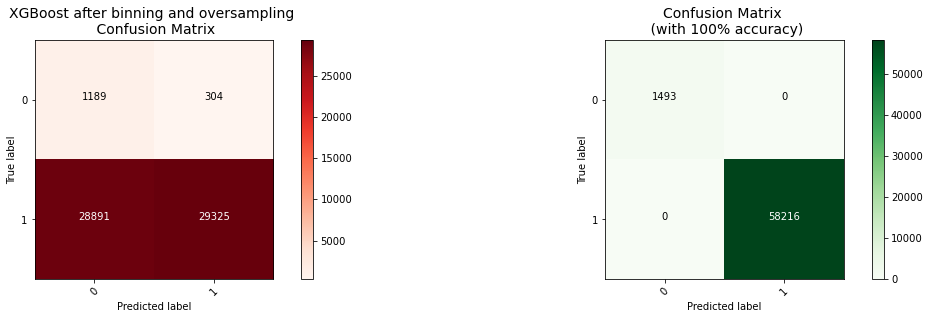

In [65]:
cm = confusion_matrix(test["event"].values, gs_xgb_ovs.predict(test_woe.drop('event', axis=1)))
actual_cm = confusion_matrix(test["event"].values,test["event"].values)
labels = ["0", "1"]

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(cm, labels, title="XGBoost after binning and oversampling \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [66]:
model_performance = model_performance.append({'model': 'XGBoost (binned & oversampled data)', 'auc': auc_xgb_ovs, 'accuracy': acc_xgb_ovs, 'precision': prec_xgb_ovs, 'recall': rec_xgb_ovs, 'f1': f1_xgb_ovs}, ignore_index=True)

### 3.4 Using Data after Augmentation

#### 3.4.1 Logistic Regression

In [67]:
pipeline_lr_aug = Pipeline([('scalar', StandardScaler()),
                            ('lr', LogisticRegression(random_state=42, class_weight='balanced'))])

param_grid_lr_aug = {'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
                     'lr__penalty': ['l1', 'l2']}

gs_lr_aug = GridSearchCV(pipeline_lr_aug, param_grid_lr_aug, scoring='roc_auc', cv=5, refit=True, n_jobs=-1, verbose=1)
gs_lr_aug.fit(train_fea_aug.drop('event', axis=1).values, train_fea_aug.event.values)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'lr__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [68]:
fpr_lr_aug, tpr_lr_aug, thresholds_lr_aug = roc_curve(test_fea_aug.event, gs_lr_aug.predict_proba(test_fea_aug.drop('event', axis=1))[:,1])
auc_lr_aug = auc(fpr_lr_aug, tpr_lr_aug)

acc_lr_aug = accuracy_score(test_fea_aug.event, gs_lr_aug.predict(test_fea_aug.drop('event', axis=1)))
prec_lr_aug = precision_score(test_fea_aug.event, gs_lr_aug.predict(test_fea_aug.drop('event', axis=1)), pos_label=0)
rec_lr_aug = recall_score(test_fea_aug.event, gs_lr_aug.predict(test_fea_aug.drop('event', axis=1)), pos_label=0)
f1_lr_aug = f1_score(test_fea_aug.event, gs_lr_aug.predict(test_fea_aug.drop('event', axis=1)), pos_label=0)

Confusion matrix, without normalization
[[ 1036   457]
 [25017 33199]]
Confusion matrix, without normalization
[[ 1493     0]
 [    0 58216]]


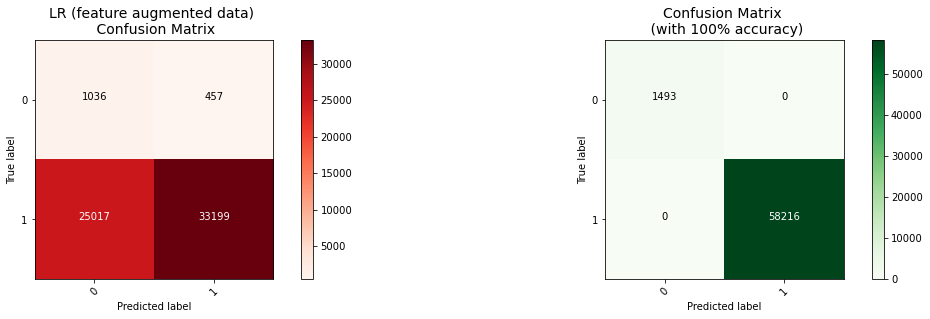

In [69]:
cm = confusion_matrix(test["event"].values, gs_lr_aug.predict(test_fea_aug.drop('event', axis=1)))
actual_cm = confusion_matrix(test["event"].values,test["event"].values)
labels = ["0", "1"]

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(cm, labels, title="LR (feature augmented data) \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [70]:
model_performance = model_performance.append({'model': 'Logistic Regression (feature augmented data)', 'auc': auc_lr_aug, 'accuracy': acc_lr_aug, 'precision': prec_lr_aug, 'recall': rec_lr_aug, 'f1': f1_lr_aug}, ignore_index=True)

#### 3.4.2 Random Forest

In [71]:
pipeline_rf_aug = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid_rf_aug = {'n_estimators': [20, 30, 50],
                     'max_depth': [3, 5, 6, 7, 8, 9, 10]}

gs_rf_aug = GridSearchCV(pipeline_rf_aug, param_grid_rf_aug, scoring='roc_auc', cv=5, refit=True, n_jobs=-1, verbose=1)
gs_rf_aug.fit(train_fea_aug.drop('event', axis=1).values, train_fea_aug.event.values)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [20, 30, 50]},
             scoring='roc_auc', verbose=1)

In [72]:
fpr_rf_aug, tpr_rf_aug, thresholds_rf_aug = roc_curve(test_fea_aug.event, gs_rf_aug.predict_proba(test_fea_aug.drop('event', axis=1))[:,1])
auc_rf_aug = auc(fpr_rf_aug, tpr_rf_aug)

acc_rf_aug = accuracy_score(test_fea_aug.event, gs_rf_aug.predict(test_fea_aug.drop('event', axis=1)))
prec_rf_aug = precision_score(test_fea_aug.event, gs_rf_aug.predict(test_fea_aug.drop('event', axis=1)), pos_label=0)
rec_rf_aug = recall_score(test_fea_aug.event, gs_rf_aug.predict(test_fea_aug.drop('event', axis=1)), pos_label=0)
f1_rf_aug = f1_score(test_fea_aug.event, gs_rf_aug.predict(test_fea_aug.drop('event', axis=1)), pos_label=0)

Confusion matrix, without normalization
[[  345  1148]
 [ 2577 55639]]
Confusion matrix, without normalization
[[ 1493     0]
 [    0 58216]]


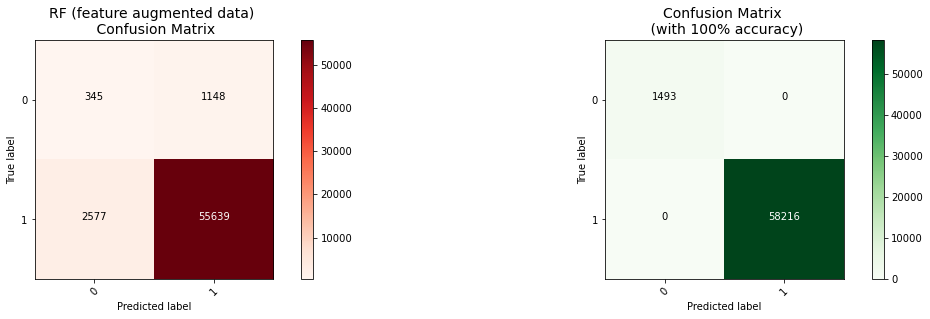

In [73]:
cm = confusion_matrix(test["event"].values, gs_rf_aug.predict(test_fea_aug.drop('event', axis=1)))
actual_cm = confusion_matrix(test["event"].values,test["event"].values)
labels = ["0", "1"]

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(cm, labels, title="RF (feature augmented data) \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [74]:
model_performance = model_performance.append({'model': 'Random Forest (feature augmented data)', 'auc': auc_rf_aug, 'accuracy': acc_rf_aug, 'precision': prec_rf_aug, 'recall': rec_rf_aug, 'f1': f1_rf_aug}, ignore_index=True)

In [76]:
feature_sel = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42, class_weight='balanced', n_jobs=-1)
feature_sel.fit(train_fea_aug.drop('event', axis=1).values, train_fea_aug.event.values)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=50,
                       n_jobs=-1, random_state=42)

In [77]:
selector = SelectFromModel(feature_sel, prefit=True, max_features=10)
train_fea_aug_sel = selector.transform(train_fea_aug.drop('event', axis=1).values)
test_fea_aug_sel = selector.transform(test_fea_aug.drop('event', axis=1).values)

#### 3.4.3 Logistic Regression After Feature Selection

In [78]:
pipeline_lr_aug_sel = Pipeline([('scaler', StandardScaler()),
                                ('lr', LogisticRegression(random_state=42, class_weight='balanced'))])

param_grid_lr_aug_sel = {'lr__C': [0.01, 0.1, 1, 10, 100],
                         'lr__penalty': ['l1', 'l2']}

gs_lr_aug_sel = GridSearchCV(pipeline_lr_aug_sel, param_grid_lr_aug_sel, scoring='roc_auc', cv=5, refit=True, n_jobs=-1, verbose=1)
gs_lr_aug_sel.fit(train_fea_aug_sel, train_fea_aug.event.values)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.01, 0.1, 1, 10, 100],
                         'lr__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [79]:
fpr_lr_aug_sel, tpr_lr_aug_sel, thresholds_lr_aug_sel = roc_curve(test_fea_aug.event, gs_lr_aug_sel.predict_proba(test_fea_aug_sel)[:,1])
auc_lr_aug_sel = auc(fpr_lr_aug_sel, tpr_lr_aug_sel)

acc_lr_aug_sel = accuracy_score(test_fea_aug.event, gs_lr_aug_sel.predict(test_fea_aug_sel))
prec_lr_aug_sel = precision_score(test_fea_aug.event, gs_lr_aug_sel.predict(test_fea_aug_sel), pos_label=0)
rec_lr_aug_sel = recall_score(test_fea_aug.event, gs_lr_aug_sel.predict(test_fea_aug_sel), pos_label=0)
f1_lr_aug_sel = f1_score(test_fea_aug.event, gs_lr_aug_sel.predict(test_fea_aug_sel), pos_label=0)

Confusion matrix, without normalization
[[  442  1051]
 [ 7483 50733]]
Confusion matrix, without normalization
[[ 1493     0]
 [    0 58216]]


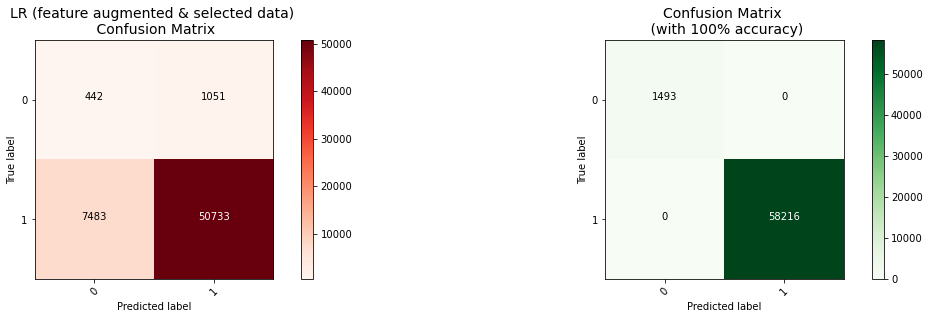

In [80]:
cm = confusion_matrix(test["event"].values, gs_lr_aug_sel.predict(test_fea_aug_sel))
actual_cm = confusion_matrix(test["event"].values,test["event"].values)
labels = ["0", "1"]

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(cm, labels, title="LR (feature augmented & selected data) \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [81]:
model_performance = model_performance.append({'model': 'Logistic Regression (feature augmented & selected data)', 'auc': auc_lr_aug_sel, 'accuracy': acc_lr_aug_sel, 'precision': prec_lr_aug_sel, 'recall': rec_lr_aug_sel, 'f1': f1_lr_aug_sel}, ignore_index=True)

### 3.5 Using Data after Random Forest Imputation

#### 3.5.1 Logistic Regression

In [82]:
pipeline_lr_rf_imp = Pipeline([('scaler', StandardScaler()),
                               ('lr', LogisticRegression(random_state=42, class_weight='balanced'))])

param_grid_lr_rf_imp = {'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
                        'lr__penalty': ['l1', 'l2']}

gs_lr_rf_imp = GridSearchCV(pipeline_lr_rf_imp, param_grid_lr_rf_imp, scoring='roc_auc', cv=5, refit=True, n_jobs=-1, verbose=1)
gs_lr_rf_imp.fit(train_rf_impute.drop('event', axis=1).values, train_rf_impute.event.values)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'lr__penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [83]:
fpr_lr_rf_imp, tpr_lr_rf_imp, thresholds_lr_rf_imp = roc_curve(test_rf_impute.event, gs_lr_rf_imp.predict_proba(test_rf_impute.drop('event', axis=1).values)[:,1])
auc_lr_rf_imp = auc(fpr_lr_rf_imp, tpr_lr_rf_imp)

acc_lr_rf_imp = accuracy_score(test_rf_impute.event, gs_lr_rf_imp.predict(test_rf_impute.drop('event', axis=1).values))
prec_lr_rf_imp = precision_score(test_rf_impute.event, gs_lr_rf_imp.predict(test_rf_impute.drop('event', axis=1).values), pos_label=0)
rec_lr_rf_imp = recall_score(test_rf_impute.event, gs_lr_rf_imp.predict(test_rf_impute.drop('event', axis=1).values), pos_label=0)
f1_lr_rf_imp = f1_score(test_rf_impute.event, gs_lr_rf_imp.predict(test_rf_impute.drop('event', axis=1).values), pos_label=0)

Confusion matrix, without normalization
[[ 1077   416]
 [27883 30333]]
Confusion matrix, without normalization
[[ 1493     0]
 [    0 58216]]


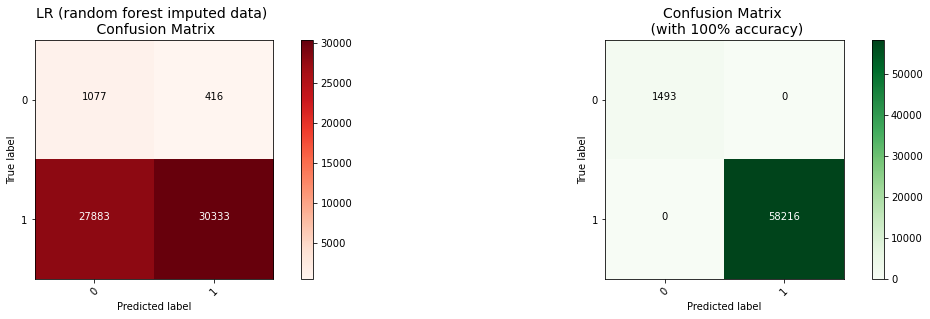

In [84]:
cm = confusion_matrix(test["event"].values, gs_lr_rf_imp.predict(test_rf_impute.drop('event', axis=1).values))
actual_cm = confusion_matrix(test["event"].values,test["event"].values)
labels = ["0", "1"]

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(cm, labels, title="LR (random forest imputed data) \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [85]:
model_performance = model_performance.append({'model': 'Logistic Regression (random forest imputed data)', 'auc': auc_lr_rf_imp, 'accuracy': acc_lr_rf_imp, 'precision': prec_lr_rf_imp, 'recall': rec_lr_rf_imp, 'f1': f1_lr_rf_imp}, ignore_index=True)

#### 3.5.2 XGBoost

In [86]:
pipeline_xgb_rf_imp = XGBClassifier(random_state=42, scale_pos_weight=1/pos_neg_ratio)

param_grid_xgb_rf_imp = {'n_estimators': [20, 30, 50],
                         'max_depth': [3, 5, 6, 7, 8, 9, 10]}

gs_xgb_rf_imp = GridSearchCV(pipeline_xgb_rf_imp, param_grid_xgb_rf_imp, scoring='roc_auc', cv=5, refit=True, n_jobs=-1, verbose=1)
gs_xgb_rf_imp.fit(train_rf_impute.drop('event', axis=1).values, train_rf_impute.event.values)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[20:14:43] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None,
                                     scale_pos_weight=0.025910207728389548,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [20, 30, 50]},
             scoring='roc_auc', verbose=1)

In [87]:
fpr_xgb_rf_imp, tpr_xgb_rf_imp, thresholds_xgb_rf_imp = roc_curve(test_rf_impute.event, gs_xgb_rf_imp.predict_proba(test_rf_impute.drop('event', axis=1).values)[:,1])
auc_xgb_rf_imp = auc(fpr_xgb_rf_imp, tpr_xgb_rf_imp)

acc_xgb_rf_imp = accuracy_score(test_rf_impute.event, gs_xgb_rf_imp.predict(test_rf_impute.drop('event', axis=1).values))
prec_xgb_rf_imp = precision_score(test_rf_impute.event, gs_xgb_rf_imp.predict(test_rf_impute.drop('event', axis=1).values), pos_label=0)
rec_xgb_rf_imp = recall_score(test_rf_impute.event, gs_xgb_rf_imp.predict(test_rf_impute.drop('event', axis=1).values), pos_label=0)
f1_xgb_rf_imp = f1_score(test_rf_impute.event, gs_xgb_rf_imp.predict(test_rf_impute.drop('event', axis=1).values), pos_label=0)

Confusion matrix, without normalization
[[ 1207   286]
 [27919 30297]]
Confusion matrix, without normalization
[[ 1493     0]
 [    0 58216]]


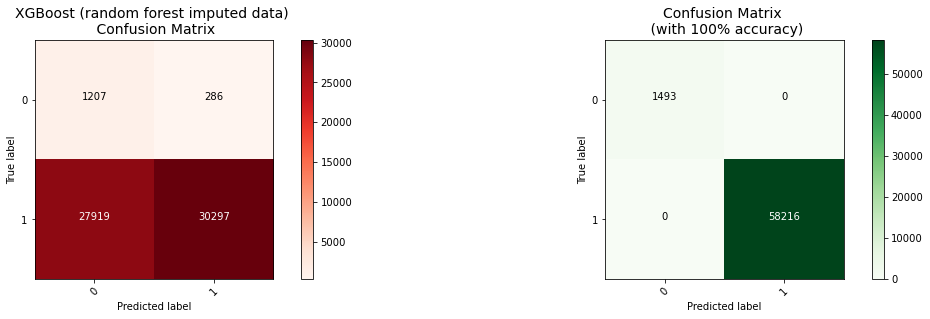

In [88]:
cm = confusion_matrix(test["event"].values, gs_xgb_rf_imp.predict(test_rf_impute.drop('event', axis=1).values))
actual_cm = confusion_matrix(test["event"].values,test["event"].values)
labels = ["0", "1"]

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(cm, labels, title="XGBoost (random forest imputed data) \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [89]:
model_performance = model_performance.append({'model': 'XGBoost (random forest imputed data)', 'auc': auc_xgb_rf_imp, 'accuracy': acc_xgb_rf_imp, 'precision': prec_xgb_rf_imp, 'recall': rec_xgb_rf_imp, 'f1': f1_xgb_rf_imp}, ignore_index=True)

## 4. Conclusion

In [90]:
model_performance.set_index('model', inplace=True)
model_performance

,auc,accuracy,precision,recall,f1
model,,,,,
XGBoost_baseline,0.73716,0.515266,0.041277,0.827194,0.07863
LogisticRegression (binned data),0.711896,0.49907,0.039955,0.826524,0.076225
RandomForest (binned data),0.726395,0.518046,0.040921,0.814468,0.077926
XGBoost (binned data),0.729424,0.505317,0.040383,0.825184,0.076998
Logistic Regression (binned & oversampled data),0.712053,0.501298,0.039978,0.823175,0.076253
Random Forest (binned & oversampled data),0.719043,0.524494,0.040769,0.799732,0.077583
XGBoost (binned & oversampled data),0.710398,0.511045,0.039528,0.796383,0.075318
Logistic Regression (feature augmented data),0.691286,0.573364,0.039765,0.693905,0.07522
Random Forest (feature augmented data),0.665119,0.937614,0.11807,0.231078,0.156285


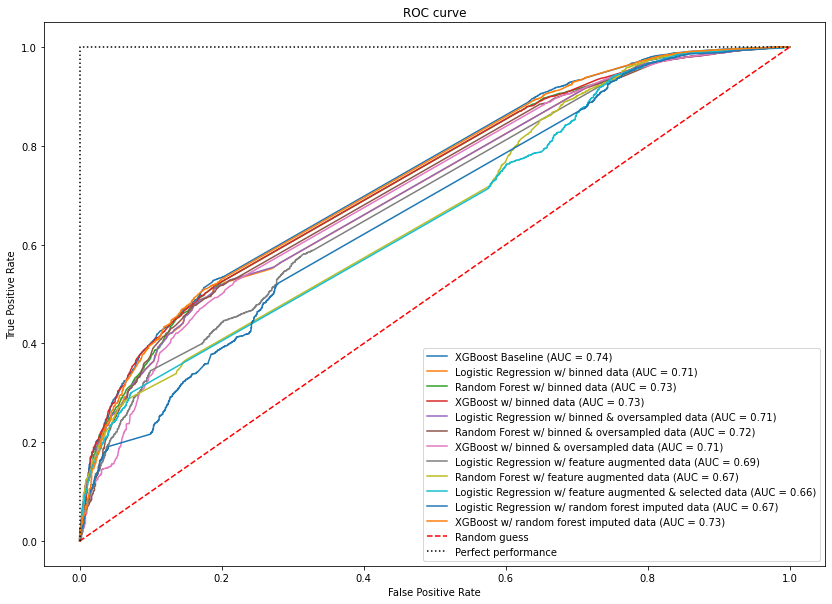

In [92]:
fig, ax = plt.subplots(figsize=(14, 10))

plt.plot(fpr_xgb_bl, tpr_xgb_bl, label='XGBoost Baseline (AUC = %0.2f)' % auc_xgb_bl)
plt.plot(fpr_lr_bin, tpr_lr_bin, label='Logistic Regression w/ binned data (AUC = %0.2f)' % auc_lr_bin)
plt.plot(fpr_rf_bin, tpr_rf_bin, label='Random Forest w/ binned data (AUC = %0.2f)' % auc_rf_bin)
plt.plot(fpr_xgb_bin, tpr_xgb_bin, label='XGBoost w/ binned data (AUC = %0.2f)' % auc_xgb_bin)
plt.plot(fpr_lr_ovs, tpr_lr_ovs, label='Logistic Regression w/ binned & oversampled data (AUC = %0.2f)' % auc_lr_ovs)
plt.plot(fpr_rf_ovs, tpr_rf_ovs, label='Random Forest w/ binned & oversampled data (AUC = %0.2f)' % auc_rf_ovs)
plt.plot(fpr_xgb_ovs, tpr_xgb_ovs, label='XGBoost w/ binned & oversampled data (AUC = %0.2f)' % auc_xgb_ovs)
plt.plot(fpr_lr_aug, tpr_lr_aug, label='Logistic Regression w/ feature augmented data (AUC = %0.2f)' % auc_lr_aug)
plt.plot(fpr_rf_aug, tpr_rf_aug, label='Random Forest w/ feature augmented data (AUC = %0.2f)' % auc_rf_aug)
plt.plot(fpr_lr_aug_sel, tpr_lr_aug_sel, label='Logistic Regression w/ feature augmented & selected data (AUC = %0.2f)' % auc_lr_aug_sel)
plt.plot(fpr_lr_rf_imp, tpr_lr_rf_imp, label='Logistic Regression w/ random forest imputed data (AUC = %0.2f)' % auc_lr_rf_imp)
plt.plot(fpr_xgb_rf_imp, tpr_xgb_rf_imp, label='XGBoost w/ random forest imputed data (AUC = %0.2f)' % auc_xgb_rf_imp)
plt.plot([0, 1], [0, 1],'r--', label='Random guess')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='black', label='Perfect performance')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

Among all those methods we try (binning, oversampling, feature augmentation, random forest imputation), we find that the baseline model (`xgb_bl`) is the best in terms of auc and recall.